<a href="https://colab.research.google.com/github/ML-Bioinfo-CEITEC/ECCB2022/blob/main/notebooks/02_Fine_tuning_CNN_model_to_your_own_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows how to fine-tune trained CNN model to your own (small) dataset. Because you probably do not have your data ready to train, we will create a new dataset by image search (DuckDuckGo). The notebook is a slight modification of Jeremy Howard's [Is it bird or not?](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) notebook from [Fastai course](https://course.fast.ai/).

First, let us install a few packages that are missing on Colab.

In [1]:
!pip install -qq timm duckduckgo_search
# ignore pip's dependency error

     |████████████████████████████████| 509 kB 26.6 MB/s 
     |████████████████████████████████| 96 kB 6.4 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


## Step 1: Searching and downloading images with DuckDuckGo

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for one photo of bird

In [3]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'https://amazinganimalphotos.com/wp-content/uploads/2016/11/beautiful-birds.jpeg'

...and then download a URL and take a look at it:

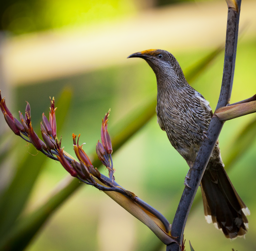

In [4]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with a "forest photo":

Searching for 'forest photos'


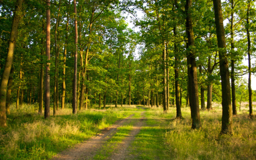

In [5]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

## Exercise

Now it is your turn to decide on 2-3 classes of images you want to classify. For example...

*   photos of bird vs. photo of forest
*   architecture styles of historical buildings (Gothic, Renaissance & Baroque)
*   photos of Bill Gates vs John Rambo
*   histology images of kidney, liver and spleen



In [15]:
# CHANGE THIS TO YOUR CATEGORIES
searches = 'kidney', 'liver', 'spleen'


path = Path('image_dataset')
from time import sleep

for o in searches:
    search_query = f'normal {o} histology' # YOU MIGHT ALSO WANT TO MODIFY THIS
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(search_query, max_images=200))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'normal kidney histology'
Searching for 'normal liver histology'
Searching for 'normal spleen histology'


In [16]:
!ls {path}

kidney	liver  spleen


Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [17]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

5

## Step 2: Train your model

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

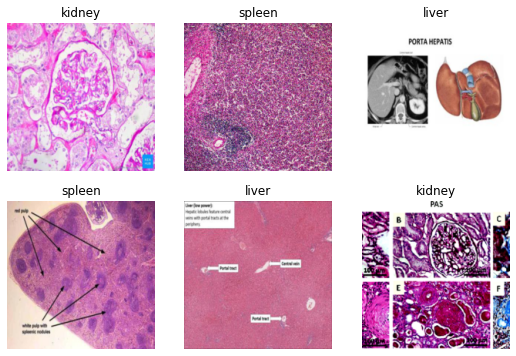

In [18]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...). If you want to select appropriate computer vision model for your purposes, [this notebook](https://www.kaggle.com/code/jhoward/which-image-models-are-best) examined a large collection of models in `timm` package.

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [19]:
# for real data, change resnet18 for better (larger) model
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.617043,0.927343,0.627660,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.699889,0.604283,0.776596,00:02
1,0.553123,0.601215,0.797872,00:02
2,0.378858,0.571143,0.808511,00:02


If the tast was simple (as bird vs forrest), there is a good chance to get a perfect classification. For more complex tasks, it is good to analyze the errors your neural network is doing, for example - the confusion matrix.

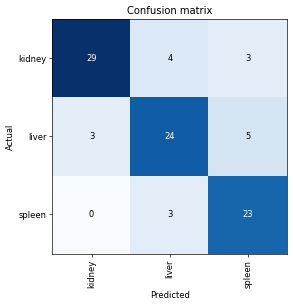

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

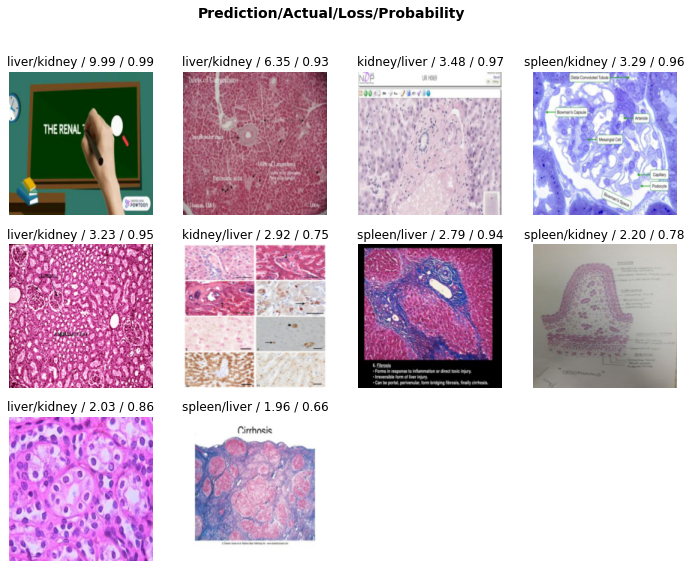

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(10)

How you can improve the training in real situation (see [Fastai book](https://github.com/fastai/fastbook)):

*   Use more data and more comple model architecture
*   Use more image transformations
*   Search for optimal learning rate (or other hyperparameters)
*   Remove wrong data points from the training set



## Step 3: Use your model

Let's see what our model thinks about that bird we downloaded at the start:

In [32]:
from google.colab import files

uploaded = files.upload()

Saving download.jpeg to download.jpeg


In [33]:
is_class,_,probs = learn.predict(PILImage.create(list(uploaded.keys())[0]))
print(f"This is a {is_class}.")
print(f"Probability it's a {is_class}: {probs.max():.4f}")

This is a spleen.
Probability it's a spleen: 0.5636


Good job, resnet18. :)

Also, you can save your trained model for using it later (for example building a web app based on it)...

In [ ]:
learn.export('model.pkl')